## Mengambil dataset fashion mnist

In [151]:
from tensorflow.keras.datasets import fashion_mnist

## Import library yang dibutuhkan

In [152]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

## Memuat dataset 

In [153]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Array nama tiap kelas

In [154]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

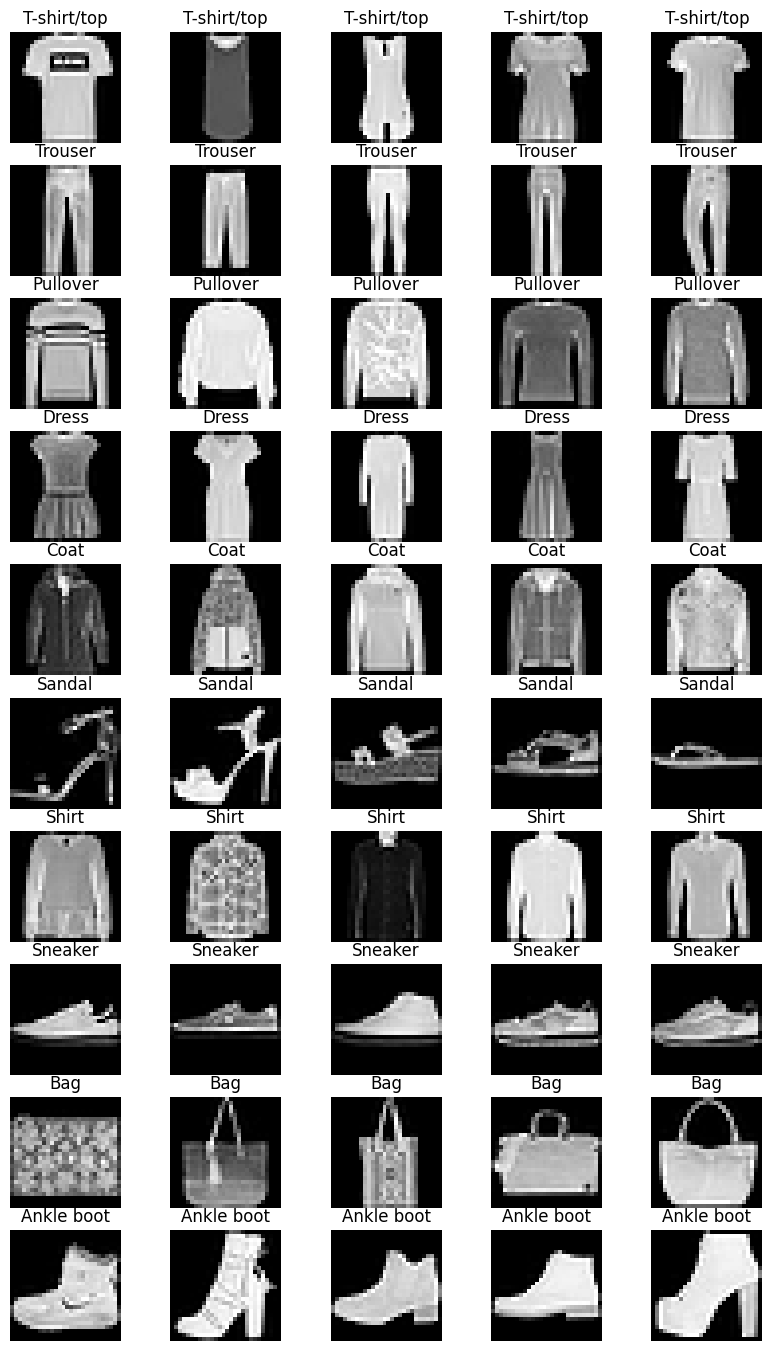

In [155]:
plt.figure(figsize=(10, 17))
images_per_class = 5
for label in range(10):
    indices = np.where(train_labels == label)[0]
    for i in range(images_per_class):
        plt.subplot(10, images_per_class, label * images_per_class + i + 1)
        plt.imshow(train_images[indices[i]], cmap='gray')
        plt.title(class_names[label])
        plt.axis('off')
plt.show()


In [156]:
print(f'Total training images: {train_images.shape[0]}')
print(f'Total test images: {test_images.shape[0]}')

Total training images: 60000
Total test images: 10000


In [157]:
# Memilih hanya kelas T-shirt/top (0) dan Trouser (1)
selected_train_indices = np.where(np.isin(train_labels, [0, 1]))
selected_test_indices = np.where(np.isin(test_labels, [0, 1]))

# Menyaring data berdasarkan indeks yang telah dipilih
train_images_selected = train_images[selected_train_indices]
train_labels_selected = train_labels[selected_train_indices]
test_images_selected = test_images[selected_test_indices]
test_labels_selected = test_labels[selected_test_indices]


In [158]:
print(f'Train images number (yang selected): {train_images_selected.shape[0]}')
print(f'Train test number (yang selected): {test_images_selected.shape[0]}')
print(f"Train images shape (yang selected): {train_images_selected.shape}")
print(f"Train labels shape (yang selected): {train_labels_selected.shape}")
print(f"Test images shape (yang selected): {test_images_selected.shape}")
print(f"Test labels shape (yang selected): {test_labels_selected.shape}")

Train images number (yang selected): 12000
Train test number (yang selected): 2000
Train images shape (yang selected): (12000, 28, 28)
Train labels shape (yang selected): (12000,)
Test images shape (yang selected): (2000, 28, 28)
Test labels shape (yang selected): (2000,)


In [159]:
# Mengubah label numerik menjadi label teks
label_mapping = {0: 'T-shirt/top', 1: 'Trouser'}
train_labels_selected_text = np.array([label_mapping[label] for label in train_labels_selected])
test_labels_selected_text = np.array([label_mapping[label] for label in test_labels_selected])


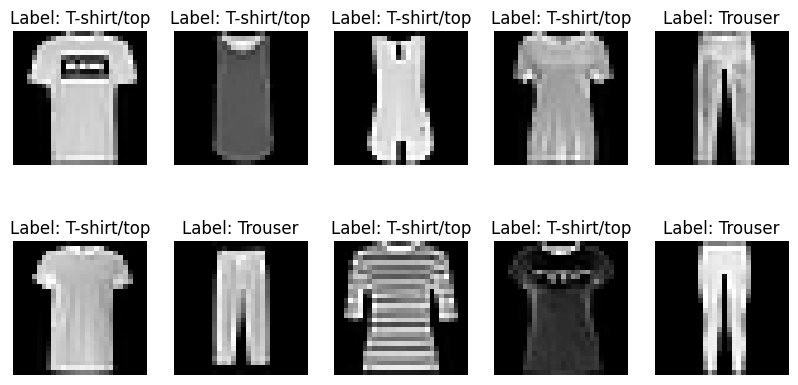

In [160]:
# Menampilkan sampel data gambar dengan label teks
plt.figure(figsize=(10, 5))
for idx in range(10):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(train_images_selected[idx], cmap='gray')
    plt.title(f'Label: {train_labels_selected_text[idx]}')
    plt.axis('off')
plt.show()


In [161]:
# Normalisasi data gambar ke rentang [0,1]
train_images_selected = train_images_selected.astype(np.float32) / 255.0
test_images_selected = test_images_selected.astype(np.float32) / 255.0

# Menambahkan dimensi channel untuk kompatibilitas dengan model CNN
train_images_selected = np.expand_dims(train_images_selected, axis=-1)
test_images_selected = np.expand_dims(test_images_selected, axis=-1)


## Arsitektur GAN Baseline

### Penjelasan
Generator:
Model menerima vektor laten yang digabungkan dengan label dalam bentuk one-hot encoding, kemudian melewati beberapa lapisan dense dengan aktivasi ReLU, dan akhirnya menghasilkan gambar 28x28 menggunakan aktivasi tanh agar nilai piksel berada dalam rentang [-1,1].

Discriminator:
Model menerima gambar yang telah di-flatten dan label sebagai input, lalu melewati beberapa lapisan dense dengan aktivasi LeakyReLU, dan akhirnya memberikan output probabilitas dengan aktivasi sigmoid untuk membedakan antara gambar asli dan palsu.

Fungsi kombinasi:
Fungsi combine_noise_and_labels menggabungkan noise dan label dalam bentuk one-hot encoding, sementara combine_images_and_labels menggabungkan gambar dengan label setelah diubah menjadi vektor satu dimensi.

Optimizers:
Optimizer Adam digunakan untuk memperbarui bobot generator dan discriminator dengan learning rate 0.0002 dan parameter beta_1=0.5 untuk stabilitas training.

Loss function:
Binary cross-entropy digunakan untuk mengukur perbedaan antara gambar nyata dan gambar hasil generasi oleh generator.

In [162]:
#func build generator
def build_generator(latent_dim, num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim + num_classes,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(28 * 28, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

# func Build discriminator
def build_discriminator(num_classes):
    img_size = 28 * 28
    model = tf.keras.Sequential([
        layers.Input(shape=(img_size + num_classes,)),
        layers.Dense(512, activation='leaky_relu'),
        layers.Dense(1024, activation='leaky_relu'),
        layers.Dense(1024, activation='leaky_relu'),
        layers.Dense(512, activation='leaky_relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Combine noise dan label
def combine_noise_and_labels(noise, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    return tf.concat([noise, label_embedding], axis=1)

# Combine gambar dan label
def combine_images_and_labels(images, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    images_flattened = tf.reshape(images, [images.shape[0], -1])
    return tf.concat([images_flattened, label_embedding], axis=1)

latent_dim = 100
num_classes = 2

# Build model generator dan discriminator
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(num_classes)

# Optimizer generator dan discriminator
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Func loss training
cross_entropy = tf.keras.losses.BinaryCrossentropy()


## Function train step

### Penjelasan
Fungsi train_step() bertugas melatih satu batch data dalam Conditional GAN.

Noise acak dibuat sebagai input generator, sementara label palsu dipilih secara acak. Generator kemudian menghasilkan gambar palsu berdasarkan noise dan label yang digabungkan.

Training Discriminator:
Gambar asli dan palsu beserta labelnya digabungkan.
Discriminator ditraining untuk membedakan gambar asli (target 1) dan palsu (target 0) menggunakan fungsi loss cross_entropy.
Gradient dihitung dan diperbarui menggunakan optimizer discriminator.

Training Generator:
Generator mencoba membuat gambar fake yang dapat menipu discriminator dengan membuat output mendekati label "asli" (1).
Loss dihitung berdasarkan kemampuan generator dalam menipu discriminator.
Gradient diperbarui dengan optimizer generator.

In [163]:
@tf.function
def train_step(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]

    # Membuat noise dan label fake
    noise = tf.random.normal([batch_size, latent_dim])
    fake_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)

    # Menghasilkan gambar fake dari generator
    fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes))

    # Menggabungkan gambar dan label real serta fake
    real_images_with_labels = combine_images_and_labels(real_images, tf.cast(real_labels, tf.int32), num_classes)
    fake_images_with_labels = combine_images_and_labels(fake_images, fake_labels, num_classes)
    combined_images_with_labels = tf.concat([real_images_with_labels, fake_images_with_labels], axis=0)

    # training discriminator
    with tf.GradientTape() as tape:
        real_output = discriminator(real_images_with_labels, training=True)
        fake_output = discriminator(fake_images_with_labels, training=True)

        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

    d_grads = tape.gradient(d_loss, discriminator.trainable_variables)
    optimizer_D.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Training generator
    noise = tf.random.normal([batch_size, latent_dim])
    misleading_labels = tf.ones([batch_size, 1])

    with tf.GradientTape() as tape:
        fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes), training=True)
        fake_output = discriminator(combine_images_and_labels(fake_images, fake_labels, num_classes), training=True)
        g_loss = cross_entropy(misleading_labels, fake_output)

    g_grads = tape.gradient(g_loss, generator.trainable_variables)
    optimizer_G.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


## Function display image

### Penjelasan
Fungsi display_images() digunakan untuk menampilkan gambar yang dihasilkan oleh generator selama proses pelatihan Conditional GAN. Generator menerima kombinasi noise dan label yang telah dikodekan sebagai input untuk menghasilkan gambar palsu. Fungsi predict() digunakan untuk melakukan inferensi. Gambar yang dihasilkan menggunakan aktivasi tanh dalam generator sehingga memiliki nilai rentang [-1,1]. Oleh karena itu, dilakukan transformasi (generated_images + 1) / 2.0 untuk membawa nilai ke dalam rentang [0,1] agar sesuai untuk ditampilkan dengan matplotlib.

In [164]:
def display_images(generator, noise, labels, epoch, num_examples=5):
    # generate gambar dari generator menggunakan combination dari noise dan label
    generated_images = generator.predict(combine_noise_and_labels(noise, labels, num_classes), verbose=0)

    # Mengubah rentang nilai piksel dari [-1,1] menjadi [0,1]
    generated_images = (generated_images + 1) / 2.0

    # Menampilkan gambar yang dihasilkan
    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()


## Train Function

### Penjelasan

Fungsi train() bertanggung jawab untuk melatih Conditional GAN selama sejumlah epoch tertentu.

List d_losses dan g_losses digunakan untuk menyimpan nilai loss discriminator dan generator di setiap epoch. Variabel best_g_loss digunakan untuk memantau perbaikan generator, dan no_improve_count untuk implementasi early stopping.

Pada setiap epoch, model dilatih dengan melakukan iterasi pada seluruh batch dalam dataset. Untuk setiap batch train_step() dipanggil untuk melakukan pelatihan 1 step. Loss dari discriminator (d_loss) dan generator (g_loss) lalu dihitung dan diakumulasikan untuk dihitung rata-rata pada akhir epoch.

Jika tidak ada penurunan pada loss generator selama 20 epoch berturut-turut (berdasarkan nilai patience), pelatihan dihentikan lebih awal untuk menghindari overfitting.

Setiap 20 epoch (sesuai dengan save_interval), fungsi display_images() dipanggil untuk menampilkan gambar hasil generator berdasarkan noise dan label random.

Setelah pelatihan selesai atau berhenti lebih awal daftar loss untuk discriminator dan generator dikembalikan untuk analisis dan visualisasi lebih lanjut.


In [165]:
def train(dataset, epochs, save_interval=10, patience=20):
    d_losses, g_losses = [], []
    best_g_loss = float('inf')
    no_improve_count = 0

    for epoch in range(epochs):
        total_d_loss, total_g_loss, batch_count = 0.0, 0.0, 0

        for image_batch, label_batch in dataset:
            d_loss, g_loss = train_step(image_batch, label_batch)
            total_d_loss += d_loss.numpy()
            total_g_loss += g_loss.numpy()
            batch_count += 1

        # Hitung rata-rata loss per epoch
        avg_d_loss = total_d_loss / batch_count
        avg_g_loss = total_g_loss / batch_count
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        print(f'Epoch {epoch + 1}, D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}')

        # early stopping
        if avg_g_loss < best_g_loss:
            best_g_loss = avg_g_loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Training stopped early at epoch {epoch + 1} due to no improvement in G loss.")
            break

        # display gambar yang dihasilkan setiap save_interval epoch
        if (epoch + 1) % save_interval == 0:
            noise = np.random.normal(0, 1, (5, latent_dim))
            labels = np.random.randint(0, num_classes, 5)
            display_images(generator, noise, labels, epoch + 1)

    return d_losses, g_losses


## Dataset dibuat dari pasangan gambar dan label, dilakukan batching dan shuffling

In [166]:
batch_size = 64
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images_selected, train_labels_selected))
    .shuffle(buffer_size=1024)
    .batch(batch_size)
)


## Training model baseline

Dilakukan training sebesar 100 epoch (dengan early stopping), dan save interval 10, setiap 10 epoch dipanggil function display images

Training baseline model.
Epoch 1, D Loss: 0.8170, G Loss: 2.2226
Epoch 2, D Loss: 0.5596, G Loss: 3.1026
Epoch 3, D Loss: 0.8757, G Loss: 2.3127
Epoch 4, D Loss: 0.8297, G Loss: 2.5169
Epoch 5, D Loss: 0.9861, G Loss: 2.0576
Epoch 6, D Loss: 1.0903, G Loss: 1.6575
Epoch 7, D Loss: 1.0415, G Loss: 1.8011
Epoch 8, D Loss: 1.0094, G Loss: 1.8052
Epoch 9, D Loss: 0.9745, G Loss: 1.8251
Epoch 10, D Loss: 0.9944, G Loss: 1.7020


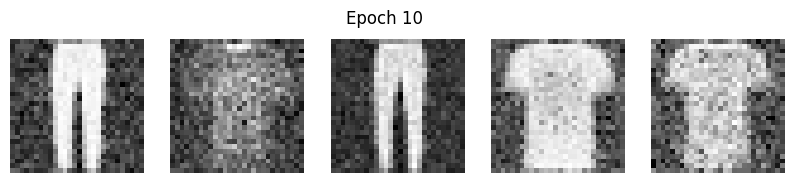

Epoch 11, D Loss: 1.0222, G Loss: 1.5829
Epoch 12, D Loss: 1.0414, G Loss: 1.5377
Epoch 13, D Loss: 1.0577, G Loss: 1.4747
Epoch 14, D Loss: 1.0798, G Loss: 1.4593
Epoch 15, D Loss: 1.0723, G Loss: 1.4551
Epoch 16, D Loss: 1.0695, G Loss: 1.4354
Epoch 17, D Loss: 1.0786, G Loss: 1.4276
Epoch 18, D Loss: 1.0848, G Loss: 1.4138
Epoch 19, D Loss: 1.0883, G Loss: 1.3761
Epoch 20, D Loss: 1.0996, G Loss: 1.3788


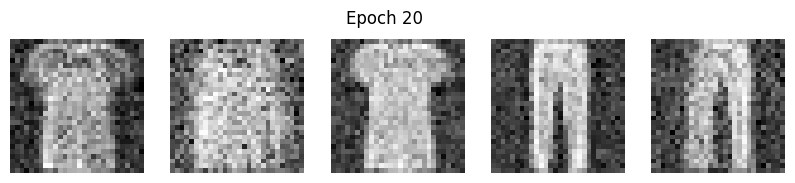

Epoch 21, D Loss: 1.1096, G Loss: 1.3344
Epoch 22, D Loss: 1.0870, G Loss: 1.3601
Epoch 23, D Loss: 1.0819, G Loss: 1.3852
Epoch 24, D Loss: 1.0879, G Loss: 1.3648
Epoch 25, D Loss: 1.0928, G Loss: 1.3489
Epoch 26, D Loss: 1.1127, G Loss: 1.3139
Epoch 27, D Loss: 1.1171, G Loss: 1.3229
Epoch 28, D Loss: 1.1035, G Loss: 1.3042
Epoch 29, D Loss: 1.1011, G Loss: 1.3167
Epoch 30, D Loss: 1.1216, G Loss: 1.2926


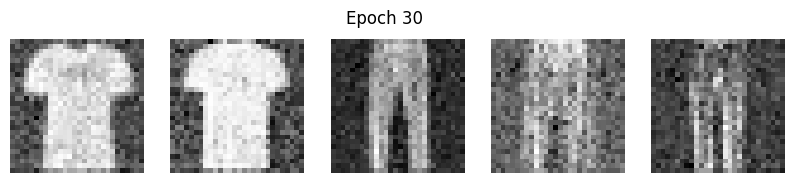

Epoch 31, D Loss: 1.1199, G Loss: 1.2679
Epoch 32, D Loss: 1.1219, G Loss: 1.2915
Epoch 33, D Loss: 1.1185, G Loss: 1.2985
Epoch 34, D Loss: 1.1292, G Loss: 1.2682
Epoch 35, D Loss: 1.1263, G Loss: 1.2617
Epoch 36, D Loss: 1.1263, G Loss: 1.2452
Epoch 37, D Loss: 1.1244, G Loss: 1.2619
Epoch 38, D Loss: 1.1268, G Loss: 1.2535
Epoch 39, D Loss: 1.1299, G Loss: 1.2476
Epoch 40, D Loss: 1.1269, G Loss: 1.2370


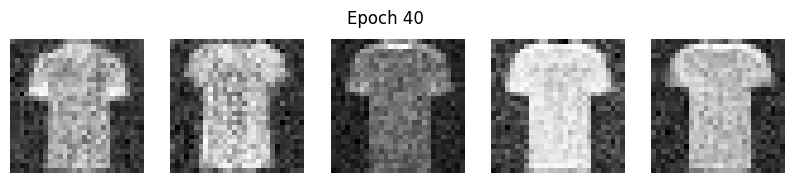

Epoch 41, D Loss: 1.1323, G Loss: 1.2454
Epoch 42, D Loss: 1.1220, G Loss: 1.2645
Epoch 43, D Loss: 1.1375, G Loss: 1.2244
Epoch 44, D Loss: 1.1294, G Loss: 1.2525
Epoch 45, D Loss: 1.1270, G Loss: 1.2600
Epoch 46, D Loss: 1.1110, G Loss: 1.2584
Epoch 47, D Loss: 1.1245, G Loss: 1.2605
Epoch 48, D Loss: 1.1250, G Loss: 1.2457
Epoch 49, D Loss: 1.1234, G Loss: 1.2647
Epoch 50, D Loss: 1.1161, G Loss: 1.2541


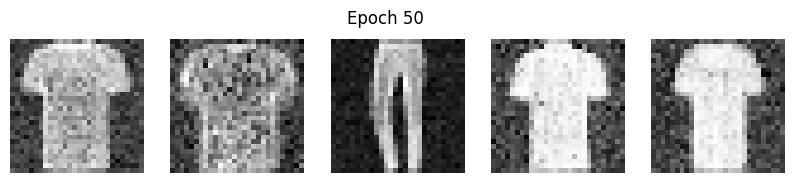

Epoch 51, D Loss: 1.1232, G Loss: 1.2633
Epoch 52, D Loss: 1.1079, G Loss: 1.2638
Epoch 53, D Loss: 1.1166, G Loss: 1.2709
Epoch 54, D Loss: 1.1059, G Loss: 1.2751
Epoch 55, D Loss: 1.1143, G Loss: 1.2475
Epoch 56, D Loss: 1.1096, G Loss: 1.2642
Epoch 57, D Loss: 1.1057, G Loss: 1.2616
Epoch 58, D Loss: 1.1032, G Loss: 1.2575
Epoch 59, D Loss: 1.1032, G Loss: 1.2471
Epoch 60, D Loss: 1.0979, G Loss: 1.2615


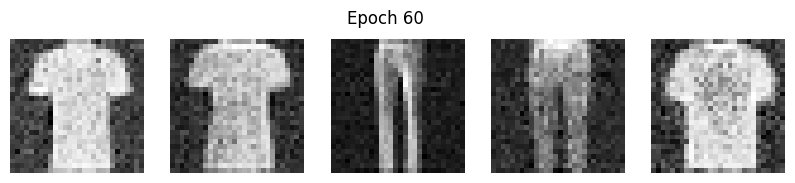

Epoch 61, D Loss: 1.0980, G Loss: 1.2779
Epoch 62, D Loss: 1.0907, G Loss: 1.2775
Epoch 63, D Loss: 1.0921, G Loss: 1.2564
Training stopped early at epoch 63 due to no improvement in G loss.


In [167]:
print("Training baseline model.")
d_losses, g_losses = train(train_dataset, epochs=100, save_interval=10)


## Plot Loss Generator dan Loss Discriminator

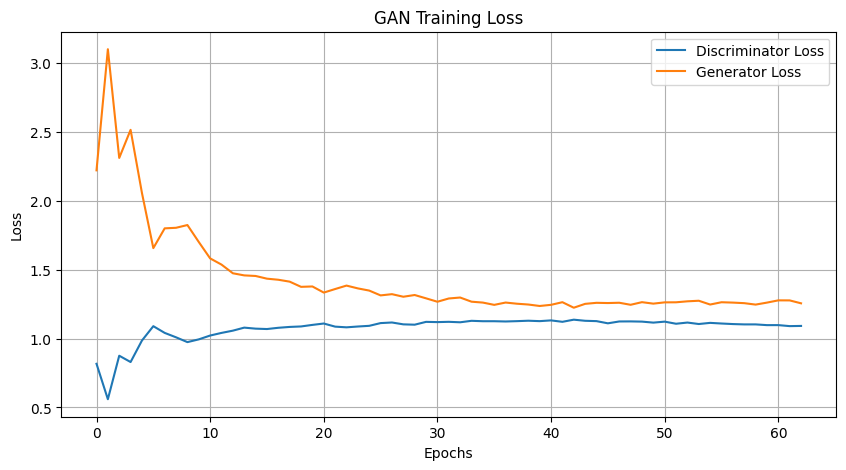

In [168]:
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_losses(d_losses, g_losses)


## Kalkulasi FID Baseline

### Penjelasan
Terdapat dua perhitungan FID yang digunakan, pertama pixel-wise menggunakan numpy biasa (Melakukan perhitungan statistik langsung pada piksel gambar yang telah di-flatten) dan kedua menggunakan InceptionV3 (sebuah model deep learning yang telah dilatih sebelumnya pada dataset ImageNet untuk mengekstraksi feature dari gambar)

#### Pixel-wise

In [169]:
def calculate_fid_score(real_imgs, fake_imgs):
    # Mengubah gambar jadi vektor 1D
    real_imgs_flat = real_imgs.reshape((real_imgs.shape[0], -1))
    fake_imgs_flat = fake_imgs.reshape((fake_imgs.shape[0], -1))

    # Menghitung rata-rata dan covariance untuk gambar real dan fake
    mean_real = np.mean(real_imgs_flat, axis=0)
    cov_real = np.cov(real_imgs_flat, rowvar=False)
    mean_fake = np.mean(fake_imgs_flat, axis=0)
    cov_fake = np.cov(fake_imgs_flat, rowvar=False)

    # Menghitung perbedaan rata-rata dan akar matriks covariance
    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_mean_sqrt = sqrtm(cov_real @ cov_fake)

    # Mengatasi kemungkinan nilai complex di hasil sqrtm
    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real

    # Frechet Inception Distance (FID)
    fid_value = mean_diff_squared + np.trace(cov_real + cov_fake - 2.0 * cov_mean_sqrt)
    return fid_value


In [170]:
# Membuat vektor noise acak untuk menghasilkan gambar palsu
noise_vector = np.random.normal(loc=0, scale=1, size=(test_images_selected.shape[0], latent_dim))

# Menggunakan label dari dataset uji sebagai label palsu untuk generator
fake_labels = test_labels_selected

# Menghasilkan gambar palsu dari generator dengan noise dan label sebagai input
fake_images = generator.predict(combine_noise_and_labels(noise_vector, fake_labels, num_classes), verbose=0)


In [171]:
# Menghitung skor FID antara gambar asli dan gambar yang dihasilkan
fid_score_baseline = calculate_fid_score(test_images_selected, fake_images)

# Menampilkan nilai FID yang dihitung
print(f'Pixel-wise FID (Baseline): {fid_score_baseline}')


Pixel-wise FID (Baseline): 6.633059081475888


Mendapatkan FID Score pixel-wise sebesar 6.6331, FID Score di bawah 10, yang berarti bahwa gambar yang dihasilkan tidak dapat dibedakan dari gambar hasil dalam feature distribution. Model sudah melakukan performa yang baik.

FID < 10: Menunjukkan gambar yang dihasilkan hampir tidak dapat dibedakan dari gambar asli

FID 10 - 50: Kualitas gambar sudah cukup bagus, tetapi butuh perbaikan

FID > 50: Gambar yang dihasilkan masih jauh dari gambar asli, perlu training lebih atau arsitektur yang lebih baik.

#### InceptionV3

In [172]:
# Function to compute the Fréchet Inception Distance (FID)
def calculate_fid_inception(real_feats, fake_feats):
    # Compute mean and covariance for both real and generated features
    mean_real = np.mean(real_feats, axis=0)
    covariance_real = np.cov(real_feats, rowvar=False)
    mean_fake = np.mean(fake_feats, axis=0)
    covariance_fake = np.cov(fake_feats, rowvar=False)

    # Compute squared difference between means
    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)

    # Compute square root of covariance matrix multiplication
    cov_sqrt_product = sqrtm(covariance_real.dot(covariance_fake))

    # Remove imaginary values if any
    if np.iscomplexobj(cov_sqrt_product):
        cov_sqrt_product = cov_sqrt_product.real

    # Calculate the FID score
    fid_value = mean_diff_squared + np.trace(covariance_real + covariance_fake - 2.0 * cov_sqrt_product)
    return fid_value

# Function to convert grayscale images to RGB format
def grayscale_to_rgb(img_array):
    return np.repeat(img_array, repeats=3, axis=-1)

# Function to resize and process images for feature extraction using InceptionV3
def extract_image_features(img_array, batch_size=32):
    features_list = []
    for start in range(0, len(img_array), batch_size):
        img_batch = img_array[start:start + batch_size]
        resized_batch = tf.image.resize(img_batch, (299, 299))
        rgb_batch = grayscale_to_rgb(resized_batch)
        preprocessed_batch = preprocess_input(rgb_batch)
        batch_features = inception_model.predict(preprocessed_batch)
        features_list.append(batch_features)

    return np.concatenate(features_list, axis=0)

# Load InceptionV3 tanpa top classification layers
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


In [173]:
# Extract features from real and generated images
real_img_features = extract_image_features(test_images_selected)
fake_img_features = extract_image_features(fake_images)

# Calculate the FID score for evaluation
fid_score_by_inception = calculate_fid_inception(real_img_features, fake_img_features)
print(f'Baseline FID (InceptionV3-based): {fid_score_by_inception}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

Dengan skor 0.2360 dari InceptionV3, model sudah mencapai kualitas yang sangat baik, di mana gambar yang dihasilkan hampir tidak dapat dibedakan dari gambar asli berdasarkan fitur yang diekstrak oleh InceptionV3. Model sudah mencapai konvergensi optimal.absabs

FID ~ 0: Semakin mendekati 0, semakin baik kualitas gambar yang dihasilkan

FID 1-10: Menunjukkan kemiripan yang tinggi, tetapi ada perbedaan yang terlihat

FID >10: Perbedaan yang cukup besar antara distribusi gambar asli dan gambar hasil generated

## Arsitektur GAN (Modified Discriminator)

### Penjelasan
Terdapat perbedaan pada arsitektur Discriminator, yang di mana awalnya:

    model.add(layers.Dense(1024, activation='leaky_relu'))
    
    model.add(layers.Dense(512, activation='leaky_relu'))

Saya coba modifikasi menjadi:

    model.add(layers.Dense(2048, activation='leaky_relu'))
    
    model.add(layers.Dense(1024, activation='leaky_relu'))

Hampir semua code cell di bawah sama dengan nomor 2 A, saya hanya menambahkan "_2" untuk berbagai variabel dan function di nomor ini agar tidak overlap antar satu sama lain.


In [174]:

# Func build generator 2 (Tidak ada perubahan)
def build_generator_2(latent_dim, num_classes):
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_dim + num_classes,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(28 * 28, activation='tanh'),
        layers.Reshape((28, 28, 1))
    ])
    return model

# Func build discriminator 2 (Ini yang modified)
def build_discriminator_2(num_classes):
    img_size = 28 * 28
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(img_size + num_classes,)))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(2048, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


# Combine noise and label (Tidak ada perubahan)
def combine_noise_and_labels_2(noise, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    return tf.concat([noise, label_embedding], axis=1)

# Combine image and label (Tidak ada perubahan)
def combine_images_and_labels_2(images, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    images_flattened = tf.reshape(images, [images.shape[0], -1])
    return tf.concat([images_flattened, label_embedding], axis=1)

latent_dim = 100
num_classes = 2


# Build discriminator 2  (Modified) dan generator 2
discriminator_2 = build_discriminator_2(num_classes)
generator_2 = build_generator_2(latent_dim, num_classes)

# Optimizers (sama dengan original)
optimizer_G_2 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D_2 = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Func loss untuk training
cross_entropy_2 = tf.keras.losses.BinaryCrossentropy()

## Func training model modified

In [175]:
def train_2(dataset, epochs, save_interval=10, patience=20):
    d_losses_2, g_losses_2 = [], []
    best_g_loss = float('inf')
    no_improve_count = 0

    for epoch in range(epochs):
        total_d_loss_2, total_g_loss_2, batch_count = 0.0, 0.0, 0

        for image_batch, label_batch in dataset:
            d_loss, g_loss = train_step_2(image_batch, label_batch)
            total_d_loss_2 += d_loss.numpy()
            total_g_loss_2 += g_loss.numpy()
            batch_count += 1

        # Calculate average loss per epoch
        avg_d_loss = total_d_loss_2 / batch_count
        avg_g_loss = total_g_loss_2 / batch_count
        d_losses_2.append(avg_d_loss)
        g_losses_2.append(avg_g_loss)

        print(f'Epoch {epoch + 1}, D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}')

        # Early stopping
        if avg_g_loss < best_g_loss:
            best_g_loss = avg_g_loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Training stopped early at epoch {epoch + 1} due to no improvement in G loss.")
            break

        # Display generated images every save_interval epochs (setiap 20)
        if (epoch + 1) % save_interval == 0:
            noise = np.random.normal(0, 1, (5, latent_dim))
            labels = np.random.randint(0, num_classes, 5)
            display_images_2(generator_2, noise, labels, epoch + 1)

    return d_losses_2, g_losses_2


## Function Train Step 2

In [176]:
@tf.function
def train_step_2(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    fake_labels_2 = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)
    fake_images_2 = generator_2(combine_noise_and_labels_2(noise, fake_labels_2, num_classes), training=True)
    real_images_with_labels_2 = combine_images_and_labels_2(real_images, tf.cast(real_labels, tf.int32), num_classes)
    fake_images_with_labels_2 = combine_images_and_labels_2(fake_images_2, fake_labels_2, num_classes)
    combined_images_with_labels_2 = tf.concat([real_images_with_labels_2, fake_images_with_labels_2], axis=0)

    with tf.GradientTape() as tape:
        real_output = discriminator_2(real_images_with_labels_2, training=True)
        fake_output = discriminator_2(fake_images_with_labels_2, training=True)

        d_loss_real = cross_entropy_2(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy_2(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

    d_grads = tape.gradient(d_loss, discriminator_2.trainable_variables)
    optimizer_D_2.apply_gradients(zip(d_grads, discriminator_2.trainable_variables))

    noise = tf.random.normal([batch_size, latent_dim])
    misleading_labels = tf.ones([batch_size, 1])

    with tf.GradientTape() as tape:
        fake_images_2 = generator_2(combine_noise_and_labels_2(noise, fake_labels_2, num_classes), training=True)
        fake_output = discriminator_2(combine_images_and_labels_2(fake_images_2, fake_labels_2, num_classes), training=True)
        g_loss = cross_entropy_2(misleading_labels, fake_output)

    g_grads = tape.gradient(g_loss, generator_2.trainable_variables)
    optimizer_G_2.apply_gradients(zip(g_grads, generator_2.trainable_variables))

    return d_loss, g_loss


## Function untuk display image per 10 epoch

In [177]:
def display_images_2(generator_2, noise, labels, epoch, num_examples=5):
    generated_images_2 = generator_2.predict(combine_noise_and_labels_2(noise, labels, num_classes), verbose=0)
    generated_images_2 = (generated_images_2 + 1) / 2.0

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated_images_2[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()


In [178]:
batch_size = 64
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_images_selected, train_labels_selected))
    .shuffle(buffer_size=1024)
    .batch(batch_size)
)


## Training model modified

Training modified model...
Epoch 1, D Loss: 0.7637, G Loss: 2.5447
Epoch 2, D Loss: 0.5534, G Loss: 3.6672
Epoch 3, D Loss: 0.7581, G Loss: 2.7791
Epoch 4, D Loss: 0.8850, G Loss: 2.3574
Epoch 5, D Loss: 0.8228, G Loss: 2.4695
Epoch 6, D Loss: 0.9525, G Loss: 2.0540
Epoch 7, D Loss: 0.9341, G Loss: 1.9605
Epoch 8, D Loss: 0.8868, G Loss: 2.1219
Epoch 9, D Loss: 0.9197, G Loss: 2.0424
Epoch 10, D Loss: 0.9015, G Loss: 1.9494


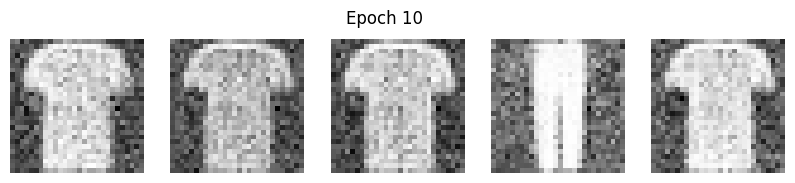

Epoch 11, D Loss: 0.9096, G Loss: 1.8727
Epoch 12, D Loss: 0.9437, G Loss: 1.7458
Epoch 13, D Loss: 0.9698, G Loss: 1.6801
Epoch 14, D Loss: 0.9887, G Loss: 1.6564
Epoch 15, D Loss: 0.9916, G Loss: 1.6342
Epoch 16, D Loss: 1.0091, G Loss: 1.5788
Epoch 17, D Loss: 1.0065, G Loss: 1.5983
Epoch 18, D Loss: 0.9929, G Loss: 1.5960
Epoch 19, D Loss: 1.0217, G Loss: 1.5517
Epoch 20, D Loss: 1.0181, G Loss: 1.5249


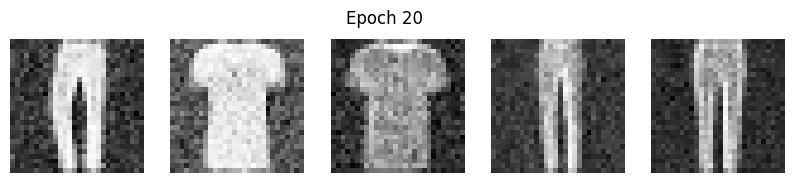

Epoch 21, D Loss: 1.0172, G Loss: 1.5464
Epoch 22, D Loss: 1.0369, G Loss: 1.5449
Epoch 23, D Loss: 1.0471, G Loss: 1.4833
Epoch 24, D Loss: 1.0458, G Loss: 1.5169
Epoch 25, D Loss: 1.0325, G Loss: 1.4843
Epoch 26, D Loss: 1.0184, G Loss: 1.5053
Epoch 27, D Loss: 1.0369, G Loss: 1.5045
Epoch 28, D Loss: 1.0507, G Loss: 1.4540
Epoch 29, D Loss: 1.0630, G Loss: 1.4430
Epoch 30, D Loss: 1.0615, G Loss: 1.4587


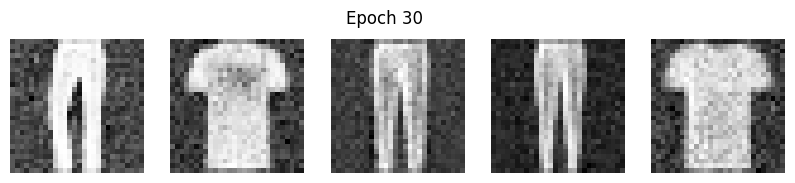

Epoch 31, D Loss: 1.0742, G Loss: 1.3980
Epoch 32, D Loss: 1.0730, G Loss: 1.4066
Epoch 33, D Loss: 1.0735, G Loss: 1.4277
Epoch 34, D Loss: 1.0635, G Loss: 1.3996
Epoch 35, D Loss: 1.0573, G Loss: 1.4159
Epoch 36, D Loss: 1.0853, G Loss: 1.3749
Epoch 37, D Loss: 1.0716, G Loss: 1.3904
Epoch 38, D Loss: 1.0714, G Loss: 1.4088
Epoch 39, D Loss: 1.0650, G Loss: 1.3923
Epoch 40, D Loss: 1.0600, G Loss: 1.4184


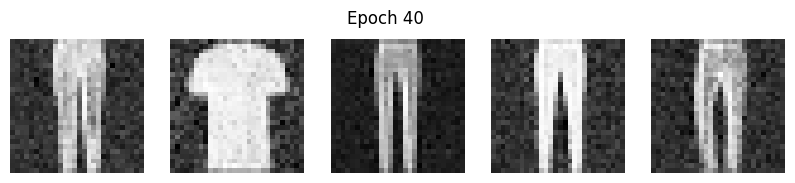

Epoch 41, D Loss: 1.0577, G Loss: 1.4259
Epoch 42, D Loss: 1.0567, G Loss: 1.4277
Epoch 43, D Loss: 1.0641, G Loss: 1.4062
Epoch 44, D Loss: 1.0738, G Loss: 1.3944
Epoch 45, D Loss: 1.0656, G Loss: 1.3927
Epoch 46, D Loss: 1.0679, G Loss: 1.3990
Epoch 47, D Loss: 1.0774, G Loss: 1.3725
Epoch 48, D Loss: 1.0737, G Loss: 1.4075
Epoch 49, D Loss: 1.0672, G Loss: 1.3871
Epoch 50, D Loss: 1.0715, G Loss: 1.3783


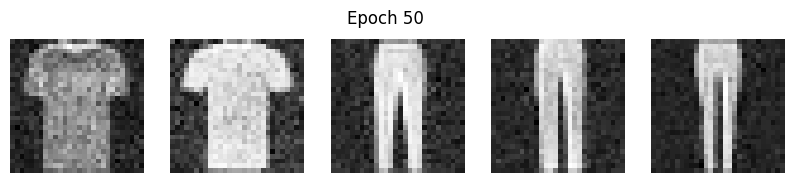

Epoch 51, D Loss: 1.0678, G Loss: 1.3616
Epoch 52, D Loss: 1.0757, G Loss: 1.3743
Epoch 53, D Loss: 1.0701, G Loss: 1.3847
Epoch 54, D Loss: 1.0672, G Loss: 1.3906
Epoch 55, D Loss: 1.0638, G Loss: 1.3770
Epoch 56, D Loss: 1.0646, G Loss: 1.3917
Epoch 57, D Loss: 1.0602, G Loss: 1.4016
Epoch 58, D Loss: 1.0483, G Loss: 1.4081
Epoch 59, D Loss: 1.0475, G Loss: 1.4220
Epoch 60, D Loss: 1.0540, G Loss: 1.4237


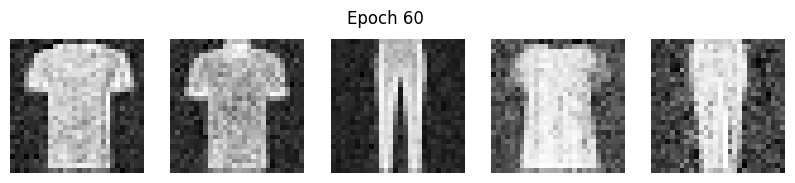

Epoch 61, D Loss: 1.0495, G Loss: 1.4068
Epoch 62, D Loss: 1.0530, G Loss: 1.4177
Epoch 63, D Loss: 1.0630, G Loss: 1.3845
Epoch 64, D Loss: 1.0393, G Loss: 1.4023
Epoch 65, D Loss: 1.0402, G Loss: 1.4169
Epoch 66, D Loss: 1.0368, G Loss: 1.4348
Epoch 67, D Loss: 1.0305, G Loss: 1.4321
Epoch 68, D Loss: 1.0339, G Loss: 1.4308
Epoch 69, D Loss: 1.0195, G Loss: 1.4371
Epoch 70, D Loss: 1.0323, G Loss: 1.4384


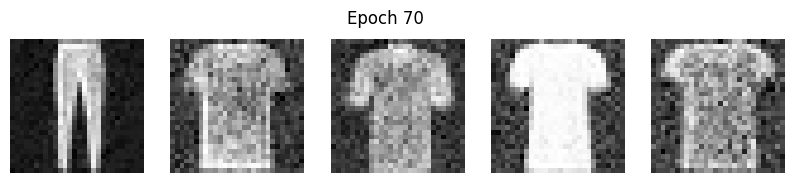

Epoch 71, D Loss: 1.0264, G Loss: 1.4721
Training stopped early at epoch 71 due to no improvement in G loss.


In [179]:
print("Training modified model...")
d_losses_2, g_losses_2 = train_2(train_dataset, epochs=100, save_interval=10)


## Plot Loss Generator dan Loss Discriminator

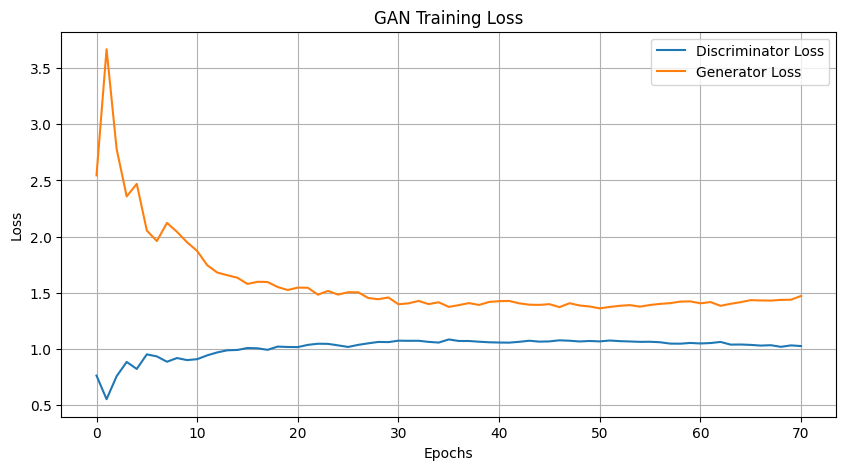

In [180]:
def plot_losses(d_losses_2, g_losses_2):
    plt.figure(figsize=(10,
                        5))
    plt.plot(d_losses_2, label="Discriminator Loss")
    plt.plot(g_losses_2, label="Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_losses(d_losses_2, g_losses_2)


## Kalkulasi FID Modified

#### Pixel-wise

In [181]:
def calculate_fid_score_2(real_imgs, fake_imgs):
    real_imgs_flat = real_imgs.reshape((real_imgs.shape[0], -1))
    fake_imgs_flat = fake_imgs.reshape((fake_imgs.shape[0], -1))

    mean_real = np.mean(real_imgs_flat, axis=0)
    cov_real = np.cov(real_imgs_flat, rowvar=False)
    mean_fake = np.mean(fake_imgs_flat, axis=0)
    cov_fake = np.cov(fake_imgs_flat, rowvar=False)

    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_mean_sqrt = sqrtm(cov_real @ cov_fake)

    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real

    fid_value = mean_diff_squared + np.trace(cov_real + cov_fake - 2.0 * cov_mean_sqrt)
    return fid_value


In [182]:
noise_vector_2 = np.random.normal(0, 1, (test_images_selected.shape[0], latent_dim))
fake_labels_2 = test_labels_selected
fake_images_2 = generator_2.predict(combine_noise_and_labels_2(noise_vector_2, fake_labels_2, num_classes), verbose=0)

In [183]:
# Menghitung FID (Pixel-wise) untuk modified model
fid_score_modified = calculate_fid_score_2(test_images_selected, fake_images_2)
print(f'Pixel-wise FID (Modified): {fid_score_modified}')

Pixel-wise FID (Modified): 5.955000268555606


#### InceptionV3

In [184]:
def calculate_fid_inception_v2(real_features, generated_features):
    mean_real = np.mean(real_features, axis=0)
    covariance_real = np.cov(real_features, rowvar=False)
    mean_fake = np.mean(generated_features, axis=0)
    covariance_fake = np.cov(generated_features, rowvar=False)
    mean_difference_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_product_sqrt = sqrtm(covariance_real @ covariance_fake)

    if np.iscomplexobj(cov_product_sqrt):
        cov_product_sqrt = cov_product_sqrt.real

    fid_score_v2 = mean_difference_squared + np.trace(covariance_real + covariance_fake - 2.0 * cov_product_sqrt)
    return fid_score_v2

def convert_to_rgb(images):
    return np.repeat(images, repeats=3, axis=-1)

def extract_features(images, batch_size=32):
    extracted_features = []
    for start in range(0, len(images), batch_size):
        batch = images[start:start + batch_size]
        resized_batch = tf.image.resize(batch, (299, 299))
        rgb_batch = convert_to_rgb(resized_batch)
        processed_batch = preprocess_input(rgb_batch)
        features_batch = inception_model.predict(processed_batch)
        extracted_features.append(features_batch)

    return np.concatenate(extracted_features, axis=0)

inception_model_v2 = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

In [185]:
real_image_features_v2 = extract_features(test_images_selected)
generated_image_features_v2 = extract_features(fake_images_2)

# Kalkulasi FID (InceptionV3-based)
fid_score_by_inception_v2 = calculate_fid_inception_v2(real_image_features_v2, generated_image_features_v2)
print(f'FID Modified (InceptionV3-based): {fid_score_by_inception_v2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

## Perbandingan Score FID antara Baseline dan Modified Architecture GAN

In [186]:
print(f'Baseline FID (Pixel-wise): {fid_score_baseline}')
print(f'Modified FID (Pixel-wise): {fid_score_modified}')

if fid_score_modified < fid_score_baseline:
    print("The modified model performs better with a lower FID score.")
else:
    print("The baseline model performs better with a lower FID score.")


Baseline FID (Pixel-wise): 6.633059081475888
Modified FID (Pixel-wise): 5.955000268555606
The modified model performs better with a lower FID score.


In [187]:
print(f'Baseline FID (InceptionV3-based): {fid_score_by_inception}')
print(f'Modified FID (InceptionV3-based): {fid_score_by_inception_v2}')

if fid_score_by_inception < fid_score_by_inception_v2:
    print("The baseline model performs better with a lower FID score by InceptionV3.")
else:
    print("The modified model performs better with a lower FID score by InceptionV3.")


Baseline FID (InceptionV3-based): 0.2360054882681648
Modified FID (InceptionV3-based): 0.20100403303138348
The modified model performs better with a lower FID score by InceptionV3.


## Kesimpulan

Model yang dimodifikasi memiliki performa lebih baik dengan pelatihan yang lebih stabil dan kualitas gambar yang lebih tinggi. Grafik loss generator dan loss discriminator menunjukkan bahwa modified model lebih seimbang antara generator dan discriminator dan skor FIDnya juga lebih rendah yang artinya lebih bagus (6.6331 buat baseline vs. 5.9550 buat modified untuk pixel-wise dan 0.2010 buat modified vs 0.2360 buat baseline untuk hasil FID pakai InceptionV3).
